In [1]:



from QuantLib import *


###################################################
##1) Inputs
###################################################

#Dates
valuation_date = Date(8,9,2020)
expiry_date = Date(27,1,2021)

#Terms and conditions
strike_price = 35
put_or_call = Option.Put

#Market data
interest_rate = SimpleQuote(0.0007)
#See idivs.org for expected dividend yields
dividend_rate = SimpleQuote(0.00)
#Dummy volatility necessary to setup process
volatility_rate = SimpleQuote(0.505)
underlying_price = SimpleQuote(42.33)

market_value = 2.10
Settings.instance().evaluation_date = valuation_date

def getProcess(interest_rate, dividend_rate, underlying_price, volatility_rate):

	###################################################
	##2) Date setup
	###################################################

	#Assumptions
	calendar = UnitedStates()
	day_counter = ActualActual()




	###################################################
	##3)
	#Curve setup
	###################################################

	interest_curve = FlatForward(valuation_date, QuoteHandle(interest_rate), day_counter )

	dividend_curve = FlatForward(valuation_date, QuoteHandle(dividend_rate), day_counter )

	volatility_curve = BlackConstantVol(valuation_date, calendar, QuoteHandle(volatility_rate), day_counter )

	#Collate market data together
	u = QuoteHandle(underlying_price)
	d = YieldTermStructureHandle(dividend_curve)
	r = YieldTermStructureHandle(interest_curve)
	v = BlackVolTermStructureHandle(volatility_curve)

	return BlackScholesMertonProcess(u, d, r, v)


###################################################
##4)
#Option setup
###################################################

def getAmericanOption(valuation_date, expiry_date, put_or_call, strike_price, process):
    grid_points = 100

    exercise = AmericanExercise(valuation_date, expiry_date)

    payoff = PlainVanillaPayoff(put_or_call, strike_price)

	#Option Setup
    option =  VanillaOption(payoff, exercise)

    time_steps = 1000
    xGrid = 1000


    engine = FdBlackScholesVanillaEngine(process, time_steps, xGrid)

    option.setPricingEngine(engine)

    return option


###################################################
##5)
##Collate results
###################################################

def getAmericanPrice(option):
    print("NPV: ", option.NPV())






process = getProcess( interest_rate, dividend_rate, underlying_price, volatility_rate)

option = getAmericanOption( valuation_date, expiry_date, put_or_call, strike_price, process)


###################################################
##6)
##Calibrate implied volatility
###################################################
implied_volatility_rate = option.impliedVolatility(market_value, process)


#volatility_rate.setValue(implied_volatility_rate)


getAmericanPrice(option)

NPV:  1.9978535003792846


In [2]:
option.NPV()

1.9978535003792846

In [3]:
implied_volatility_rate

0.5179769553789837

In [4]:
u0 = (underlying_price.value())
p0 = option.NPV()

h = 0.01
underlying_price.setValue(u0+h)
P_plus = option.NPV()
underlying_price.setValue(u0-h)
P_minus = option.NPV()
underlying_price.setValue(u0)

delta = (P_plus - P_minus) / (2*h)
gamma =  (P_plus - 2*p0 + P_minus) / (h*h)

print ( delta)
print ( gamma )


-0.17516599353536444
0.01925012175663099


In [5]:
h = 0.0001
sigma0 = volatility_rate.value()
volatility_rate.setValue(sigma0+h)
P_plus = option.NPV()
volatility_rate.setValue(sigma0)
vega = (P_plus - p0)/h
print(vega)

7.199039082375069


In [6]:
Settings_instance().evaluationDate = valuation_date - 1
process = getProcess( interest_rate, dividend_rate, underlying_price, volatility_rate)

option = getAmericanOption( valuation_date, expiry_date, put_or_call, strike_price, process)
p1 = option.NPV()
h = 1.0 /365
theta = (p1-p0)/h
print(theta)

0.0


In [7]:
option.NPV()

1.464578922471293

In [8]:
p0

1.464578922471293

In [9]:
sigma = volatility_rate.value()
print(sigma)
volatility_rate.setValue(0.48)
sigma = volatility_rate.value()
print(sigma)

0.48
0.48


In [10]:
import numpy as np
price_table = np.zeros((20,40))
for vol in range(25,65,1):
    volatility_rate.setValue(vol/100)
    for un in range(32,52,1):
        underlying_price.setValue(un)
        price_table[un-32][vol-25] = option.NPV()

In [11]:
price_table

array([[3.92572372, 3.99745148, 4.06999109, 4.14326045, 4.21718744,
        4.29170847, 4.36676726, 4.44231383, 4.51830368, 4.59469703,
        4.67145823, 4.74855524, 4.82595914, 4.90364383, 4.98158562,
        5.05976298, 5.13815633, 5.21674774, 5.29552083, 5.37446056,
        5.45355309, 5.5327857 , 5.61214661, 5.69162493, 5.77121059,
        5.85089418, 5.93066701, 6.01052093, 6.09044836, 6.17044217,
        6.25049571, 6.33060274, 6.41075739, 6.4909541 , 6.57118766,
        6.65145315, 6.7317459 , 6.81206149, 6.89239573, 6.97274465],
       [3.27378377, 3.35336429, 3.43331898, 3.5136062 , 3.59418966,
        3.6750376 , 3.7561221 , 3.83741849, 3.91890488, 4.0005618 ,
        4.08237184, 4.16431935, 4.24639027, 4.32857189, 4.41085268,
        4.49322216, 4.57567078, 4.65818981, 4.7407712 , 4.8234076 ,
        4.9060922 , 4.98881869, 5.07158127, 5.1543745 , 5.23719332,
        5.32003304, 5.40288923, 5.48575775, 5.56863473, 5.65151649,
        5.73439958, 5.81728073, 5.90015684, 5.9

In [15]:
import pandas as pd

df_table = pd.DataFrame(price_table,columns=list(range(25,65,1)))
df_table['Underlying'] =  list(range(32,52,1))
df_table =df_table.set_index('Underlying')
df_table.head()
df_table.to_csv("Simulation.csv")

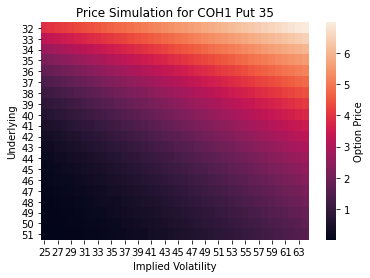

In [14]:
import seaborn as sb

ax = sb.heatmap(df_table, cbar_kws={'label':'Option Price'})
ax.set_xlabel('Implied Volatility')
ax.set_title('Price Simulation for COH1 Put 35')
fig = ax.get_figure()
fig.savefig("Heatmap.png")




In [150]:
print(len(list(range(25,65,1))))
print(len(list(range(32,52,1))))

40
20
